<a href="https://colab.research.google.com/github/andreidore/deep-rl-tf2/blob/master/dqn/dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Paper** [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)<br>
**Author** Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, Martin Riedmiller<br>
**Method** OFF-Policy / Temporal-Diffrence / Model-Free<br>
**Action** Discrete only<br>


Install openai gym

In [15]:
!pip install wandb
!pip install gym gym[atari]
!apt-get install python-opengl -y
!apt install xvfb -y


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


For rendering environment, you can use pyvirtualdisplay.

In [16]:
!pip install pyvirtualdisplay
!pip install piglet

To activate virtual display we need to run a script once for training an agent, as follows:

In [17]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1015'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1015'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test"  
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import base64
import io
import os
import glob
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import random
from collections import deque
import tensorflow as tf
import numpy as np
from IPython.display import HTML
from IPython import display as ipythondisplay
import wandb


In [21]:
print(tf.__version__)

2.2.0-rc3


In [22]:
tf.keras.backend.set_floatx('float64')
wandb.init(name='DQN-Colab', project="deep-rl-tf2")

W&B Run: https://app.wandb.ai/andrei-dore/deep-rl-tf2/runs/3ugqnfjw

In [23]:
print("Start DQN")

Start DQN


## Constants

In [0]:
GAMMA=0.95
LR=0.005
BATCH_SIZE=32
EPSILON=1.0
EPSILON_DECAY=0.995
EPSILON_MIN=0.01

## Replay Buffer

In [0]:
class ReplayBuffer():

  def __init__(self,capacity=10000):
    self.buffer=deque(maxlen=capacity)

  def put(self,state,action,reward,next_state,is_done):
    self.buffer.append([state,action,reward,next_state,is_done])

  def sample(self, batch_size):

    sample = random.sample(self.buffer, batch_size)
    states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
    states = np.array(states).reshape(batch_size, -1)
    next_states = np.array(next_states).reshape(batch_size, -1)

    return states, actions, rewards, next_states, done

  def size(self):
        return len(self.buffer)




## Model

In [0]:
class ActionStateModel():
  def __init__(self, state_dimension, action_dimension, lr=LR, epsilon=EPSILON, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN):

    self.state_dimension=state_dimension
    self.action_dimension=action_dimension

    self.lr=lr
    self.epsilon=epsilon
    self.epsilon_decay=epsilon_decay
    self.epsilon_min=epsilon_min

    self.model=self.create_model()


  def create_model(self):

    model=tf.keras.Sequential([
              tf.keras.layers.Input(self.state_dimension),
              tf.keras.layers.Dense(32,activation="relu"),
              tf.keras.layers.Dense(16,activation="relu"),
              tf.keras.layers.Dense(self.action_dimension)
    ])

    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr))

    return model


  def predict(self, state):

    return self.model.predict(state)


  def train(self, states, targets):

    self.model.fit(states, targets, epochs=1, verbose=0)

  def get_action(self, state):

    self.epsilon=self.epsilon*self.epsilon_decay
    self.epsilon=max(self.epsilon, self.epsilon_min)

    # Exploration
    if np.random.random()<self.epsilon:
      return np.random.randint(0,self.action_dimension-1)

    # Exploitation
    state=np.reshape(state,[1,self.state_dimension])
    q_value = self.predict(state)[0]

    return np.argmax(q_value)

    
    







## Agent

In [0]:
class Agent():
  def __init__(self, env, batch_size=BATCH_SIZE,gamma=GAMMA):
    self.env=env
    self.batch_size=batch_size
    self.gamma=gamma
    self.state_dimension=env.observation_space.shape[0]
    self.action_dimension=env.action_space.n

    self.model= ActionStateModel(self.state_dimension, self.action_dimension)
    self.target_model= ActionStateModel(self.state_dimension, self.action_dimension)

    self.buffer=ReplayBuffer()

  def update_target(self):
    weights=self.model.model.get_weights()
    self.target_model.model.set_weights(weights)

  def replay(self):

    for _ in range(10):

      states,actions,rewards,next_states,done=self.buffer.sample(self.batch_size)

      targets=self.target_model.predict(states)
      next_q_values=self.target_model.predict(next_states).max(axis=1)
      targets[range(self.batch_size),actions]=rewards+(1-done)*next_q_values*self.gamma
      self.model.train(states,targets)

  


  def train(self, max_episodes=1000):

    total_rewards=[]

    for episode in range(max_episodes):
      done, total_reward = False, 0

      state=self.env.reset()

      while not done:

        action=self.model.get_action(state)

        next_state, reward, done, _ = self.env.step(action)

        self.buffer.put(state, action, reward*0.01, next_state, done)

        total_reward+=reward

        state=next_state


      if self.buffer.size()>=self.batch_size:
        self.replay()

      self.update_target()
      total_rewards.append(total_reward)
      print("Episode:{} Reward:{}".format(episode,total_reward))
      wandb.log({'Reward': total_reward})

    return total_rewards
    
      




## Run

In [28]:
env = gym.make('CartPole-v1')
print(env.action_space)
agent = Agent(env)
total_rewards=agent.train(max_episodes=1000)

Discrete(2)
Episode:0 Reward:9.0
Episode:1 Reward:10.0
Episode:2 Reward:10.0
Episode:3 Reward:8.0
Episode:4 Reward:10.0
Episode:5 Reward:8.0
Episode:6 Reward:10.0
Episode:7 Reward:10.0
Episode:8 Reward:8.0
Episode:9 Reward:10.0
Episode:10 Reward:10.0
Episode:11 Reward:10.0
Episode:12 Reward:8.0
Episode:13 Reward:10.0
Episode:14 Reward:9.0
Episode:15 Reward:10.0
Episode:16 Reward:10.0
Episode:17 Reward:10.0
Episode:18 Reward:10.0
Episode:19 Reward:9.0
Episode:20 Reward:9.0
Episode:21 Reward:16.0
Episode:22 Reward:8.0
Episode:23 Reward:9.0
Episode:24 Reward:12.0
Episode:25 Reward:9.0
Episode:26 Reward:10.0
Episode:27 Reward:12.0
Episode:28 Reward:18.0
Episode:29 Reward:9.0
Episode:30 Reward:9.0
Episode:31 Reward:12.0
Episode:32 Reward:9.0
Episode:33 Reward:13.0
Episode:34 Reward:9.0
Episode:35 Reward:10.0
Episode:36 Reward:9.0
Episode:37 Reward:14.0
Episode:38 Reward:14.0
Episode:39 Reward:20.0
Episode:40 Reward:31.0
Episode:41 Reward:14.0
Episode:42 Reward:14.0
Episode:43 Reward:29.0
Ep

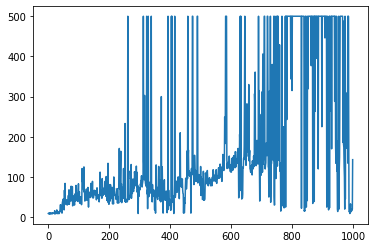

In [29]:
plt.plot(total_rewards)

##  Random action

In [30]:
env = wrap_env(gym.make("CartPole-v1"))
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()

## DQN action

In [31]:
env = wrap_env(gym.make("CartPole-v1"))
state = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    #action = env.action_space.sample() 

    #print(state)
    #print(state.shape)
    state=state=np.reshape(state,[1,4])

    actions=agent.model.predict(state)
    a=np.argmax(actions)
    #print(a)
         
    state, reward, done, info = env.step(a) 
   
        
    if done: 
      break;
            
env.close()
show_video()